# Hate Speech Classification using 1D CNN with Tensorflow

### Task 1: Import Packages and Functions

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
plt.style.use('fivethirtyeight')
print(tf.__version__)

2.2.0


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Task 2: Load and Explore Data

In [4]:
# Load data
df = pd.read_csv('comments.csv').fillna(' ')

In [5]:
# Split into training and test sets
train_df = df.sample(frac=0.8)
test_df = df.sample(frac=0.2)

In [6]:
train_df.sample(10,random_state=1)

,Unnamed: 0,comment_text,toxic
47742,80527,"""\n\n Just curious \n\nWhere did you find that...",0
56625,82609,"Hello everyone, i am doing this topic too, and...",0
54713,158251,u need to stop ur disruptive editing in the ar...,0
79826,119068,"""\nWelcome!\n\nHello, , and welcome to Wikiped...",0
73113,141848,Image Offered \n\nI've uploaded the following ...,0
61538,5912,The ACS match lists are the bedrock of all cri...,0
98746,91718,savant13 is a fat shite,1
4320,139060,want your version. It should be easier for you...,0
1562,38390,"""\nNow that I'm thinking about it, another fre...",0
73396,117221,"Also, go ahead on using the word resurrection ...",0


In [7]:
# View few toxic comments
x = train_df['comment_text']
y = train_df['toxic']

In [8]:
train_df[train_df.toxic==1]

,Unnamed: 0,comment_text,toxic
70838,16388,"Whatever, dude. Fuck off.",1
58904,87105,Bully for you! But the only lies here are of y...,1
56010,88517,FUAK U MUDDAFAKA \n\nyou are so suck dik at di...,1
14577,47832,I dont understand how to talk back but my edit...,1
60044,129787,"Why don't you kiss my ass, prick.",1
...,...,...,...
1487,141525,"NO, i prefer, i will continue to attack Gerald...",1
73769,95616,"""\n\n.......good one spelling nazi.......I ass...",1
68891,138802,Gamaliel is a spic asshole with an axe to grin...,1
10923,73937,"""\n\nvandalism?! is this your idea of a JOKE? ...",1


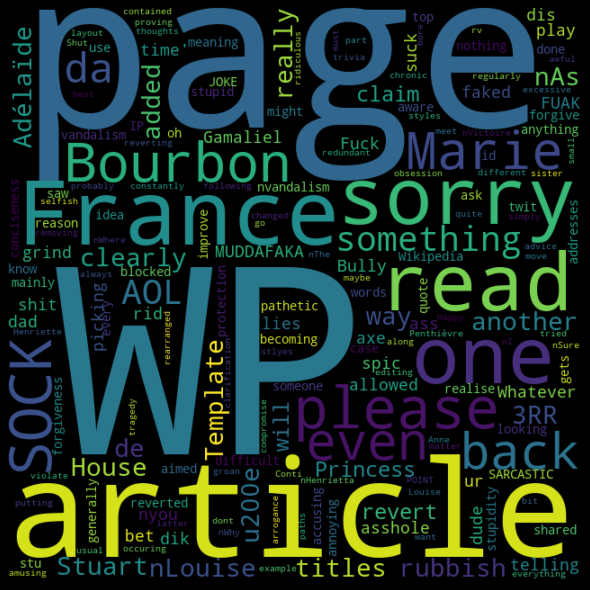

In [9]:
comments = train_df['comment_text'].loc[train_df['toxic']==1].values
wordcloud = WordCloud(
    width = 640,
    height = 640,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(comments))
fig = plt.figure(
    figsize = (12, 8),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


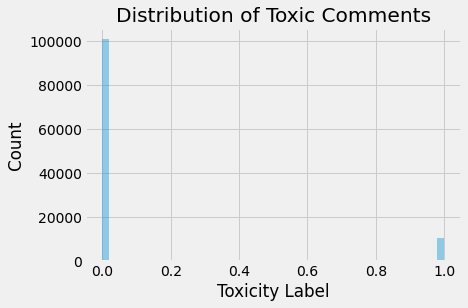

In [10]:
# Plot frequency of toxic comments
fig = sns.distplot(df['toxic'], kde=False)
plt.xlabel("Toxicity Label")
plt.ylabel("Count")
plt.title("Distribution of Toxic Comments")
plt.show(fig)

In [11]:
train_df['toxic'].value_counts()

0    80807
1     8553
Name: toxic, dtype: int64

### Task 3: Data Prep — Tokenize and Pad Text Data

In [12]:
max_features = 20000
max_text_length = 400

In [13]:
x_tokenizer = text.Tokenizer(max_features)
x_tokenizer.fit_on_texts(list(x))

In [14]:
x_tokenized = x_tokenizer.texts_to_sequences(x)
x_train_val= sequence.pad_sequences(x_tokenized, maxlen=max_text_length)

### Task 4: Prepare Embedding Matrix with Pre-trained GloVe Embeddings

In [15]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -q glove.6B.zip

In [16]:
embedding_dim =100
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    embeddings_index[word]= coefs
f.close()
print(f'Found {len(embeddings_index)} word vectors')

Found 400000 word vectors


In [17]:
embedding_matrix= np.zeros((max_features,embedding_dim))
for word, index in x_tokenizer.word_index.items():
    if index>max_features-1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index]= embedding_vector
            

### Task 5: Build the Model

In [18]:
filters= 250
kernel_size=3
hidden_dims= 250


In [19]:
model = Sequential()
model.add(Embedding(max_features,
                    embedding_dim,
                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                    trainable=False))
model.add(Dropout(0.2))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(filters,
                 5,
                 padding='valid',
                 activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         2000000   
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 250)         75250     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 250)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 250)         312750    
_________________________________________________________________
global_max_pooling1d (Global (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 250)               6

### Task 6: Compile Model

In [20]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

### Task 7: Splitting the data into training and validation set

In [21]:
x_train,x_val,y_train,y_val = train_test_split(x_train_val,y,test_size=0.3,random_state=1)

### Task 8: Model Fitting/Training

In [22]:
batch_size= 32
epochs = 3
hist = model.fit(x_train,y_train,
                    batch_size= batch_size,
                    epochs=epochs,
                    validation_data= (x_val,y_val)
                    )

Epoch 1/3
1955/1955 [==============================] - 22s 11ms/step - loss: 0.1553 - accuracy: 0.9446 - val_loss: 0.1248 - val_accuracy: 0.9524
Epoch 2/3
1955/1955 [==============================] - 22s 11ms/step - loss: 0.1267 - accuracy: 0.9533 - val_loss: 0.1175 - val_accuracy: 0.9545
Epoch 3/3
1955/1955 [==============================] - 22s 11ms/step - loss: 0.1145 - accuracy: 0.9573 - val_loss: 0.1109 - val_accuracy: 0.9585


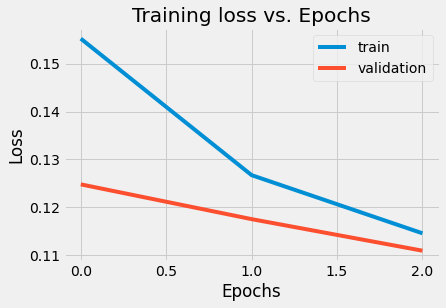

In [23]:
# Plot loss
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss vs. Epochs')
plt.legend()
plt.show()

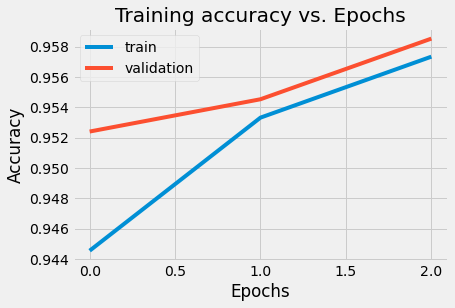

In [24]:
# Plot accuracy
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs. Epochs')
plt.legend()
plt.show()

### Task 9: Evaluate Model

In [25]:
x_test = test_df['comment_text'].values
y_test = test_df['toxic'].values

In [26]:
x_test_tokenized = x_tokenizer.texts_to_sequences(x_test)
x_testing = sequence.pad_sequences(x_test_tokenized,maxlen=max_text_length)

In [27]:
y_pred = model.predict(x_testing,verbose=1,batch_size=32)

699/699 [==============================] - 3s 4ms/step


In [28]:
y_pred = [0 if y[0] < 0.5 else 1 for y in y_pred]

In [29]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))

Accuracy: 96.43%


In [30]:
print("F1 Score: {:.6f}".format(f1_score(y_test, y_pred, average='macro')))

F1 Score: 0.883062


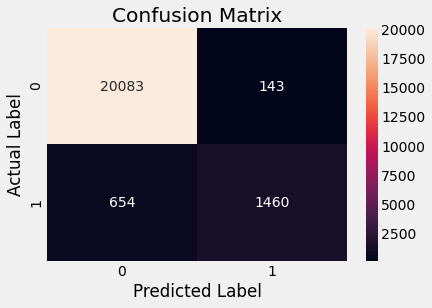

In [31]:
cm = confusion_matrix(y_test, y_pred)
fig = sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show(fig)

### Extras: View our results!

In [32]:
test_df['prediction'] = [ 'not toxic' if x<0.5 else 'toxic' for x in y_pred]

In [33]:
test_df[['comment_text','prediction']].head(20)

,comment_text,prediction
51445,"""\nI don't know what is meant by """"Tajik chara...",not toxic
3692,Be weary of your TW \n\nDid you even read anyt...,not toxic
98609,"It is not promotional, it's all factual. Young...",not toxic
12419,Your edits to Ramtha\nThese edits appear to vi...,not toxic
51289,"Or, If I scan you the sources, is it possible ...",not toxic
89510,Chaetopterus - some time in the future it appe...,not toxic
16909,"Shelly, A. \n\nNext thing we know you'll be ta...",not toxic
68188,"""\n == Image:Maintitle.jpg listed for deletion...",not toxic
45819,Thank you for your interest. Cleanup work is f...,not toxic
60139,"""\nYou have confused something here. My only e...",not toxic
